In [1]:
import pyautogui
import cv2
from pynput.mouse import Button, Controller
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle
import cv2
from PIL import Image 


mouse = Controller()

In [2]:
def get_locations():
    locations = {}
    messages = ["Put your mouse on the upper left of the canvas","Put your mouse on the bottom right of the canvas", "Hover the colour palette", "Hover the hex colour box (after the # if there is one)", "Hover the ok box","new layer button"]
    ans = "n"
    for i,x in enumerate(messages):
        print(x)
        ans = "n"
        while ans == "n":
            ans = input("Leave mouse in correct position. Are you ready? y/n")
    
        locations[i] = pyautogui.position()
        
    x_size = locations[1][0] - locations[0][0]
    y_size = locations[1][1] - locations[0][1]
    
    return locations, x_size, y_size
    
    

In [3]:
def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image



In [4]:
def reduce_image(img_path,n_colors=32):
    base_img = cv2.imread(img_path)
    h,w,_ = base_img.shape
    ratio = h/w
    base_img_resized = cv2.resize(base_img,(int(y_size/ratio),int(y_size)))    
    base_img_resized = np.array(base_img_resized, dtype=np.float64) / 255
    w, h, d = original_shape = tuple(base_img_resized.shape)
    assert d == 3
    image_array = np.reshape(base_img_resized, (w * h, d))
    image_array_sample = shuffle(image_array, random_state=0)[:1000]
    kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
    labels = kmeans.predict(image_array)
    codebook_random = shuffle(image_array, random_state=0)[:n_colors]
    labels_random = pairwise_distances_argmin(codebook_random,
                                              image_array,
                                              axis=0)

    img = recreate_image(kmeans.cluster_centers_, labels, w, h)
    img_new = cv2.cvtColor((img*255).astype(np.uint8),cv2.COLOR_RGB2BGR)
    return img_new

In [5]:
def get_hex(r, g, b):
    return '#%02x%02x%02x' % (r, g, b)

In [6]:
def get_hex_keys(img):
    unique_keys = {}

    for y in img_new:
        for x in y:
            hexx = get_hex(x[0],x[1],x[2])
            if not hexx in unique_keys.keys():
                unique_keys[hexx] = hexx
    return unique_keys

In [7]:
def change_colour(new_hex):
    #move to palette
    pyautogui.sleep(1)
    pyautogui.click(locations[2][0], locations[2][1])
    pyautogui.sleep(0.2)
    
    #click hex box
    pyautogui.click(locations[3][0], locations[3][1])
    pyautogui.sleep(0.2)
    
    #delete in box
    pyautogui.press('del', presses=8,interval=0.05*sleep_multiplier)
    
    #write new one 
    pyautogui.write(new_hex, interval=0.05*sleep_multiplier) 
    pyautogui.sleep(0.2)
    #press enter
    #pyautogui.press('return', presses=1,interval=0.05)
    #pyautogui.PAUSE = 0.2

    #click hex box
    pyautogui.click(locations[4][0], locations[4][1])
    pyautogui.sleep(0.2*sleep_multiplier)

In [8]:
def draw_pos(startX,startY,posX,posY,release=True,only=False):
    #move to palette
    if release:
        mouse.release(Button.left)
        pyautogui.sleep(0.008*sleep_multiplier)
    
    if not only:
        mouse.position = (int(startX+posX), int(startY+posY))
        pyautogui.sleep(0.0025*sleep_multiplier)
    
    if release and not only:
        mouse.press(Button.left)
        pyautogui.sleep(0.008*sleep_multiplier)


In [9]:
def new_layer():
    pyautogui.click(locations[5][0], locations[5][1])
    pyautogui.sleep(0.2*sleep_multiplier)
    pyautogui.press('return')
    pyautogui.sleep(0.5*sleep_multiplier)

In [10]:
def draw(img, keys, brush_size=2,perc=1,frm=True,reverse=True,layers=True):    
    i = 0
    times_draw = 0
    sorted_keys = sorted(list(unique_keys.keys()),key=lambda x: int(x.replace("#",""),16),reverse=reverse)
    
    if frm:
        sorted_keys = sorted_keys[:int(len(sorted_keys)*perc)]
    else:
        sorted_keys = sorted_keys[int(len(sorted_keys)*perc):]
        
    for col in sorted_keys:
        change_colour(col.replace("#",""))
        for iy,y in enumerate(img):
            for ix,x in enumerate(y):
                if times_draw == 0 and col == get_hex(x[0],x[1],x[2]):
                    draw_pos(locations[0][0], locations[0][1],ix*brush_size,iy*brush_size,True)
                    i += 1   
                    times_draw+=1                    
                if col == get_hex(x[0],x[1],x[2]) and times_draw >0:
                    draw_pos(locations[0][0], locations[0][1],ix*brush_size,iy*brush_size,False)                
                else:
                    times_draw = 0
                    
            pyautogui.sleep(0.01*sleep_multiplier)
            times_draw=0
            draw_pos(None,None,None,None,True,True)    
            
        pyautogui.sleep(0.5*sleep_multiplier)
                    
        if layers:            
            new_layer()

In [11]:
sleep_multiplier = 1.1

In [12]:
locations, x_size, y_size = get_locations()

Put your mouse on the upper left of the canvas


Leave mouse in correct position. Are you ready? y/n y


Put your mouse on the bottom right of the canvas


Leave mouse in correct position. Are you ready? y/n y


Hover the colour palette


Leave mouse in correct position. Are you ready? y/n y


Hover the hex colour box (after the # if there is one)


Leave mouse in correct position. Are you ready? y/n y


Hover the ok box


Leave mouse in correct position. Are you ready? y/n y


new layer button


Leave mouse in correct position. Are you ready? y/n y


In [20]:
img_new = reduce_image("leila.jpg",16)

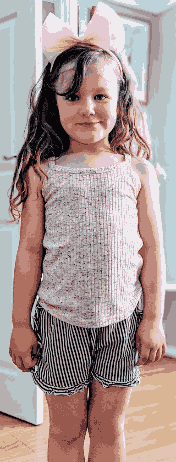

In [21]:
Image.fromarray(img_new)

In [22]:
unique_keys = get_hex_keys(img_new)

In [23]:
draw(img_new,unique_keys,2,reverse=False)

In [ ]:
draw(img_new,unique_keys,2,.92,frm=False)